In [1]:
from gerrychain import Graph, Election, updaters, Partition, MarkovChain, constraints
from gerrychain.proposals import recom
from gerrychain.accept import always_accept
from gerrychain.tree import random_spanning_tree, PopulatedGraph, predecessors
from collections import deque, namedtuple
from functools import partial
from collections import Counter
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
Cut = namedtuple("Cut", "edge subset")


##########################################################################################
#     THIS IS NO LONGER NEEDED, BUT IS HANDY FOR CHECKING THE SIZE OF THE PARTITIONS     #
#                 TURN IT OFF AND REMOVE CONSTRAINT FOR ACTUAL RUNS                      #
##########################################################################################
# def stop_disappearing(partition):                                                      #
#     if not partition.parent:                                                           #
#         return True                                                                    #
#     sizes_now = [len(part) for part in partition.assignment.parts.values()]            #
#     sizes_past = [len(part) for part in partition.parent.assignment.parts.values()]    #
#     print(sizes_now, min(sizes_past), max(sizes_past))                                 #
#     return all(len(part) > 1 for part in partition.assignment.parts.values())          #
##########################################################################################


def find_balanced_edge_cuts(h, choice=random.choice):
    root = choice([x for x in h if h.degree(x) > 2])
    pred = predecessors(h.graph, root)
    cuts = []
    leaves = deque(x for x in h if h.degree(x) == 1)
    while len(leaves) > 0:
        leaf = leaves.popleft()
        cuts.append(Cut(edge=(leaf, pred[leaf]), subset=h.subsets[leaf].copy()))
        parent = pred[leaf]
        h.contract_node(leaf, parent)
        if h.degree(parent) == 1 and parent != root:
            leaves.append(parent)
            
    even_split = int(len(h.graph.nodes)/2)
    #cut_lengths is number of nodes in one of the districts after cut of a specific edge
    cut_lengths = np.asarray([len(cuts[i].subset) for i in range(len(cuts))])
    cut_distances = np.abs(cut_lengths-even_split)
    cut_distances, cuts = zip(*sorted(zip(cut_distances, cuts)))
    cut_distances = list(filter(lambda a: a != max(cut_distances), cut_distances))
    
    temp_d = {}
    for i in range(len(cut_distances)):
        temp_d[i] = cut_distances[i]
    print(temp_d)
        # indices of cut_distances
    population = list(range(len(cut_distances)))
    weight_small_d = (1/(np.asarray(cut_distances)**2+1))
    probs = weight_small_d/sum(weight_small_d)
#     print(probs)
    choice = random.choices(population, probs)[0]
#     print(choice)
############################################################################## 
#   VERIFIES THAT YOU ARE SAMPLING FROM ALL POSSIBLE EDGE CHOICES CORRECTLY  #
##############################################################################
#     d = Counter(random.choices(population, probs, k=100000))               #
#     fig = plt.figure(figsize=(12,12))                                      #
#     ax = fig.add_subplot(2, 1, 1)                                          #
#     plt.bar(d.keys(), d.values(), width=1.0, color='g')                    #
#     ax.set_yscale('log')                                                   #
#     plt.show()                                                             #
#     print(d)                                                               #
##############################################################################
    return [cuts[choice]]


def partition_tree(graph, pop_col, pop_target, epsilon, node_repeats=1, spanning_tree=None, choice=random.choice):
    populations = {node: graph.nodes[node][pop_col] for node in graph}
    possible_cuts = []
    spanning_tree = random_spanning_tree(graph)
    while len(possible_cuts) == 0:
        spanning_tree = random_spanning_tree(graph)
        h = PopulatedGraph(spanning_tree, populations, pop_target, epsilon)
        possible_cuts = find_balanced_edge_cuts(h, choice=choice)
    return choice(possible_cuts).subset

In [2]:
###################################################################
#                    *HASHING AND COMPRESSING*                    #
# THE PythonObjectEncoder CLASS SERIALIZES GENERIC PYTHON OBJECTS #
#         THESE OBJECTS CAN THEN BE COMPRESSED AND SAVED          #
###################################################################
from json import JSONEncoder, dumps, loads
from io import BytesIO
import hashlib
import pickle
import gzip
from os import path


class PythonObjectEncoder(JSONEncoder):
    def __init__(self, partition):
        self.partition = partition
        self.keys = sorted(list(initial_partition.parts.keys()))
        self.objstrings = []
        self.hashstrings = []
        self.d_plan = dict.fromkeys(self.keys)
        
        
    def __call__(self, obj):
        if isinstance(obj, (list, dict, str, bytes, int, float, bool, type(None))):
            return JSONEncoder.default(self, obj)
        return {'_python_object': pickle.dumps(obj)}
    
    
    def update(self, partition):
        for i in range(len(self.keys)):
            self.d_plan[self.keys[i]] = list(partition.assignment.parts[self.keys[i]])
        encoded_plan = dumps(self.d_plan)
        compressed_plan = PythonObjectEncoder.compressStringToBytes(encoded_plan)
        hashstring = hashlib.md5(encoded_plan.encode('utf-8')).hexdigest()
        self.objstrings.append(compressed_plan)
        self.hashstrings.append(hashstring)
        
        
    def commit(self, file_name):
        final_table = dict(zip(self.hashstrings,self.objstrings))
        self.save_obj(final_table, file_name)
        
        
    def load_maps(self, file_name):
        decode_test = self.load_obj(file_name)
        recreated_maps = []
        for key in decode_test:
            recreated_maps.append(loads(PythonObjectEncoder.decompressBytesToString(decode_test[key])))
        return recreated_maps
        
    
    @staticmethod
    def compressStringToBytes(inputString):
        bio = BytesIO()
        bio.write(inputString.encode("utf-8"))
        bio.seek(0)
        stream = BytesIO()
        compressor = gzip.GzipFile(fileobj=stream, mode='w')
        while True:
            chunk = bio.read(8192)
            if not chunk:
                compressor.close()
                return stream.getvalue()
            compressor.write(chunk)

            
    @staticmethod
    def decompressBytesToString(inputBytes):
        bio = BytesIO()
        stream = BytesIO(inputBytes)
        decompressor = gzip.GzipFile(fileobj=stream, mode='r')
        while True:
            chunk = decompressor.read(8192)
            if not chunk:
                decompressor.close()
                bio.seek(0)
                return bio.read().decode("utf-8")
            bio.write(chunk)
        return None
    
    
    @staticmethod
    def save_obj(obj, name):
        if path.exists(name + '.pkl'):
            prev_map = PythonObjectEncoder.load_obj(name)
            final_map = {**prev_map, **obj}
            with open(name + '.pkl', 'rb+') as f:
                pickle.dump(final_map, f, pickle.HIGHEST_PROTOCOL)
        else:
            with open(name + '.pkl', 'wb') as f:
                pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
        
    @staticmethod
    def load_obj(name):
        with open(name + '.pkl', 'rb') as f:
            return pickle.load(f)

In [3]:
filename = "TX_vtds_fixed"
graph = Graph.from_json(f"{filename}.json")

office, year = "PRES", "16"
pop_used = "TOTPOP"
area = "area"
assign = "USCD"

elect = office + year
elect_D = elect + "D"
elect_R = elect + "R"

elections = Election(elect, {"Dem": elect_D, "Rep": elect_R})

my_updaters = {"population": updaters.Tally(pop_used, alias="population"), elect: elections}
initial_partition = Partition(
    graph,
    assignment=assign,
    updaters=my_updaters
)

ideal_population = sum(initial_partition["population"].values()) / len(initial_partition)

proposal = partial(
    recom,
    pop_col=pop_used,
    pop_target=ideal_population,
    epsilon=1,
    node_repeats=2,
    method=partition_tree
)

chain = MarkovChain(
    proposal=proposal,
    accept=always_accept,
    constraints = [constraints.contiguous],
    initial_state=initial_partition,
    total_steps=5
)

running
{0: 50, 1: 52, 2: 53, 3: 54, 4: 62, 5: 80, 6: 81, 7: 84, 8: 87, 9: 90, 10: 102, 11: 104, 12: 105, 13: 106, 14: 109, 15: 112, 16: 113, 17: 119, 18: 121, 19: 122, 20: 123, 21: 124, 22: 126, 23: 127, 24: 130, 25: 131, 26: 142, 27: 143, 28: 144, 29: 145, 30: 150, 31: 156, 32: 158, 33: 165, 34: 169, 35: 170, 36: 199, 37: 201, 38: 207, 39: 208, 40: 213, 41: 213, 42: 218, 43: 219, 44: 220, 45: 220, 46: 221, 47: 221, 48: 222, 49: 223, 50: 224, 51: 225, 52: 226, 53: 227, 54: 229, 55: 230, 56: 231, 57: 232, 58: 232, 59: 233, 60: 233, 61: 236, 62: 236, 63: 237, 64: 237, 65: 239, 66: 240, 67: 240, 68: 241, 69: 242, 70: 243, 71: 243, 72: 243, 73: 243, 74: 244, 75: 244, 76: 244, 77: 244, 78: 245, 79: 246, 80: 246, 81: 246, 82: 247, 83: 248, 84: 248, 85: 248, 86: 249, 87: 249, 88: 249, 89: 249, 90: 250, 91: 250, 92: 250, 93: 251, 94: 251, 95: 252, 96: 252, 97: 252, 98: 252, 99: 253, 100: 253, 101: 254, 102: 254, 103: 254, 104: 255, 105: 256, 106: 256, 107: 256, 108: 256, 109: 256, 110: 257, 1

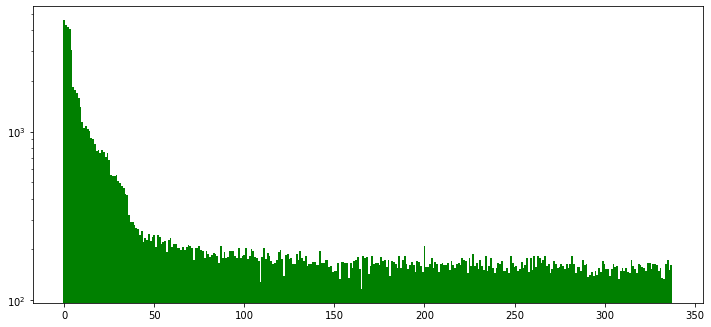

Counter({0: 4607, 1: 4287, 2: 4160, 3: 4078, 4: 3065, 5: 1838, 6: 1769, 7: 1697, 8: 1582, 9: 1405, 10: 1135, 12: 1083, 11: 1049, 13: 1041, 14: 1006, 15: 914, 16: 907, 17: 844, 19: 776, 21: 775, 18: 765, 22: 752, 20: 751, 24: 747, 23: 708, 25: 683, 26: 554, 29: 552, 28: 547, 27: 547, 30: 506, 31: 499, 32: 477, 33: 460, 34: 424, 35: 423, 36: 321, 38: 291, 37: 290, 39: 281, 40: 267, 41: 263, 43: 259, 47: 247, 42: 245, 52: 243, 50: 242, 49: 238, 53: 238, 45: 235, 59: 235, 46: 229, 58: 227, 56: 223, 48: 223, 55: 222, 44: 222, 54: 216, 62: 216, 61: 215, 69: 212, 70: 210, 75: 209, 87: 209, 200: 209, 68: 208, 66: 207, 51: 206, 60: 206, 71: 205, 74: 205, 73: 204, 101: 204, 97: 203, 111: 203, 64: 203, 63: 203, 104: 200, 120: 199, 65: 199, 76: 198, 67: 198, 105: 197, 93: 197, 131: 196, 142: 196, 77: 195, 94: 195, 92: 195, 79: 195, 89: 193, 119: 192, 57: 192, 113: 191, 83: 190, 80: 189, 124: 188, 227: 188, 84: 187, 129: 187, 100: 186, 82: 186, 123: 185, 95: 184, 99: 184, 234: 184, 282: 183, 134: 1

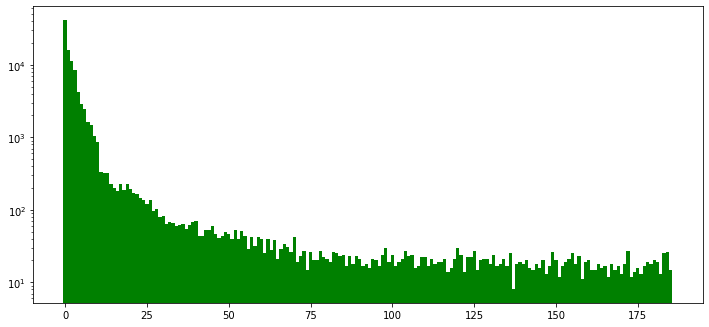

Counter({0: 41841, 1: 16018, 2: 11323, 3: 8481, 4: 4263, 5: 2857, 6: 2493, 7: 1629, 8: 1461, 9: 1050, 10: 870, 11: 330, 13: 318, 12: 317, 14: 230, 19: 226, 17: 225, 15: 199, 20: 193, 18: 189, 16: 183, 21: 173, 22: 163, 23: 144, 26: 138, 24: 137, 25: 122, 28: 104, 27: 95, 30: 82, 29: 79, 40: 70, 39: 68, 32: 67, 33: 65, 31: 63, 36: 63, 35: 62, 38: 61, 45: 59, 34: 59, 37: 54, 52: 53, 43: 52, 44: 52, 54: 51, 49: 49, 46: 47, 50: 46, 55: 44, 42: 44, 48: 44, 41: 44, 57: 42, 70: 42, 59: 42, 47: 41, 60: 40, 51: 40, 53: 39, 62: 39, 64: 38, 67: 34, 58: 32, 68: 31, 98: 30, 120: 30, 66: 29, 56: 29, 63: 28, 125: 27, 73: 27, 78: 27, 104: 27, 172: 27, 82: 26, 69: 26, 184: 26, 149: 26, 75: 26, 61: 25, 83: 25, 136: 25, 183: 25, 155: 25, 131: 24, 121: 24, 106: 24, 97: 24, 85: 24, 100: 24, 157: 23, 89: 23, 105: 23, 87: 23, 72: 23, 84: 23, 123: 22, 79: 22, 110: 22, 124: 22, 109: 22, 94: 21, 80: 21, 65: 21, 90: 21, 134: 21, 112: 21, 119: 21, 103: 21, 129: 21, 154: 21, 116: 21, 128: 21, 77: 20, 180: 20, 150:

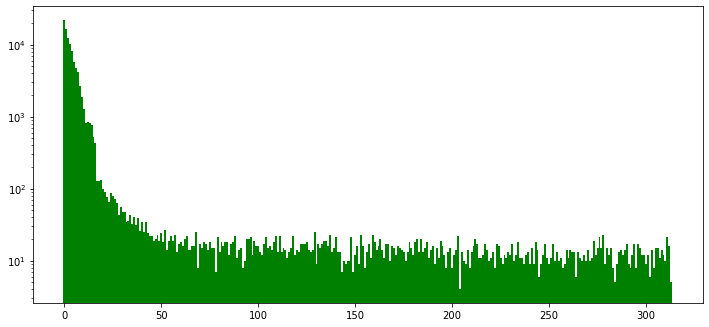

Counter({0: 22188, 1: 16570, 2: 12520, 3: 10309, 4: 8177, 5: 5754, 6: 4811, 7: 4212, 8: 2628, 9: 1859, 10: 1275, 12: 849, 11: 826, 13: 822, 14: 766, 15: 523, 16: 435, 19: 132, 17: 128, 18: 126, 20: 100, 21: 90, 24: 86, 25: 80, 22: 77, 26: 72, 23: 66, 27: 63, 29: 55, 31: 48, 30: 47, 28: 43, 34: 43, 36: 41, 38: 39, 33: 36, 32: 35, 42: 35, 40: 34, 35: 32, 37: 31, 52: 27, 39: 26, 68: 25, 129: 25, 41: 25, 43: 24, 50: 24, 159: 23, 153: 23, 48: 23, 57: 23, 278: 23, 137: 23, 45: 22, 63: 22, 44: 22, 88: 22, 118: 22, 109: 22, 55: 22, 203: 22, 111: 22, 79: 21, 311: 21, 140: 21, 96: 21, 276: 21, 148: 21, 104: 21, 184: 20, 95: 20, 94: 20, 62: 20, 182: 20, 212: 20, 47: 20, 163: 20, 134: 19, 49: 19, 194: 19, 46: 19, 273: 19, 98: 19, 54: 19, 56: 19, 135: 19, 87: 18, 234: 18, 51: 18, 160: 18, 72: 18, 60: 18, 83: 18, 75: 18, 181: 18, 81: 18, 187: 18, 84: 18, 125: 18, 108: 18, 178: 18, 243: 18, 131: 17, 290: 17, 103: 17, 133: 17, 123: 17, 252: 17, 166: 17, 73: 17, 124: 17, 167: 17, 248: 17, 70: 17, 231: 

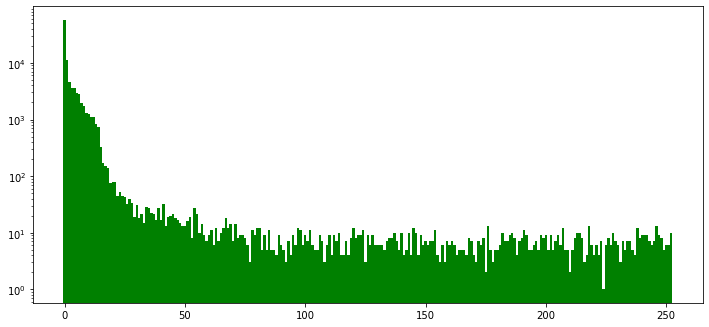

Counter({0: 57784, 1: 11365, 2: 4655, 3: 3548, 4: 3541, 5: 2912, 6: 2845, 7: 1949, 8: 1761, 9: 1313, 10: 1261, 11: 1108, 12: 1098, 13: 838, 14: 749, 15: 328, 16: 172, 17: 153, 18: 138, 21: 78, 20: 78, 19: 75, 23: 53, 22: 45, 24: 44, 25: 42, 27: 39, 28: 33, 26: 32, 41: 32, 30: 31, 34: 29, 54: 27, 39: 27, 35: 27, 36: 22, 55: 21, 37: 21, 45: 21, 32: 21, 44: 20, 29: 19, 43: 19, 52: 19, 46: 18, 31: 18, 67: 18, 38: 17, 47: 17, 40: 17, 51: 16, 48: 15, 33: 15, 71: 14, 69: 14, 57: 14, 176: 13, 49: 13, 218: 13, 50: 13, 246: 13, 42: 13, 207: 12, 97: 12, 68: 12, 80: 12, 145: 12, 120: 12, 238: 12, 63: 12, 66: 12, 81: 12, 98: 11, 61: 11, 191: 11, 85: 11, 154: 11, 102: 11, 78: 11, 124: 11, 114: 10, 213: 10, 140: 10, 252: 10, 65: 10, 56: 10, 182: 10, 186: 10, 146: 10, 228: 10, 137: 10, 143: 10, 214: 10, 60: 9, 200: 9, 205: 9, 122: 9, 79: 9, 74: 9, 123: 9, 185: 9, 100: 9, 242: 9, 240: 9, 202: 9, 126: 9, 89: 9, 83: 9, 106: 9, 112: 9, 241: 9, 247: 9, 95: 9, 58: 9, 128: 9, 148: 9, 73: 9, 198: 9, 110: 9, 1

In [4]:
%%time

poe = PythonObjectEncoder(initial_partition)

for partition in chain:
    poe.update(partition)
    print("running")

In [ ]:
poe.commit('test')

In [107]:
%%time
poe.commit('test')

CPU times: user 43.7 ms, sys: 48.1 ms, total: 91.7 ms
Wall time: 89.3 ms


In [108]:
%%time
reloaded_maps = poe.load_maps('test')

CPU times: user 7.5 s, sys: 1.01 s, total: 8.52 s
Wall time: 8.51 s


In [109]:
print(len(reloaded_maps))

3059


In [11]:
trials = 5
steps = 5
epsil = 1
for i in range(trials):
    chain = MarkovChain(
        proposal=proposal,
        accept=always_accept,
        constraints = [constraints.contiguous],
        initial_state=initial_partition,
        total_steps=steps
    )

    print('first check')
    data = pd.DataFrame(
        sorted(partition[elect].percents("Dem"))
        for partition in chain.with_progress_bar()
    )

    #print(data)
    
    print('second check')
    for k in np.arange(0,steps,1):
        data2 = pd.DataFrame(data.iloc[k]).transpose().reset_index(drop=True)
        data2['StepNum'] = k+1
        data2['RunNum'] = i

        if (i == 0) and (k == 0):
            with open('p_Week_Run_e{0}.csv'.format(int(epsil*100)), 'a') as file:
                data2.to_csv(file, header=True)
        else:
            with open('p_Week_Run_e{0}.csv'.format(int(epsil*100)), 'a') as file:
                data2.to_csv(file, header=False)

    print("Previously Completed Step: {0}".format(i))

first check



second check
Previously Completed Step: 0
first check



second check
Previously Completed Step: 1
first check



second check
Previously Completed Step: 2
first check



second check
Previously Completed Step: 3
first check



second check
Previously Completed Step: 4


In [ ]:
######################################################
##############     importing libraries  ##############
######################################################

from gerrychain import (
                        Graph, Partition, Election,
                        updaters, constraints, accept,
                        MarkovChain
                        )
from gerrychain.updaters import Tally, cut_edges, perimeter, exterior_boundaries, boundary_nodes, interior_boundaries, cut_edges_by_part
from gerrychain.metrics import polsby_popper, efficiency_gap
from gerrychain.proposals import recom, propose_random_flip
from functools import partial
from gerrychain.accept import always_accept
import pandas
import random
import numpy as np
import tqdm
import sys


  #### Custom functions that allow us to create conditions to accept a move
filename = "TX_vtds_fixed"
graph = Graph.from_json(f"{filename}.json")

# Creates a way to quickly change election office, election year, assignment map, and population
office, year = "PRES", "16"
pop_used = "TOTPOP"
area = "area"
assign = "USCD"

steps = 2000
epsil = 9999

# Finishes creation of quick refereces for election cycles
elect = office + year
elect_D = elect + "D"
elect_R = elect + "R"

elections = Election(elect, {"Dem": elect_D, "Rep": elect_R})

k_in = 1
    
def objective_score(partition, k=k_in):
    comp = sum(polsby_popper(partition).values())/(len(partition))
    eg = abs(efficiency_gap(partition[elect]))
    return k*comp + (1-k)*(1-eg)


def custom_objective(partition):
    if partition.parent == None:
        return False
    else:
        new = objective_score(partition)
        old = objective_score(partition.parent)
        if new > old:
            return True
        else:
            bound = min(1, new/old)
            rand = random.random()
            return rand <= bound

def noWorseThanInitial(partition):
    if sum(polsby_popper(partition).values())/len(partition) >= sum(polsby_popper(initial_partition).values())/len(initial_partition):
        return True
    else:
        return False


######################################################
################     creating graph  #################
######################################################
i=0

while i < 100:


    #######################################################
    ###########     creating initial partition  ###########
    #######################################################

    initial_partition = Partition(
        graph,
        assignment=assign,
        updaters={
            #"cut_edges": cut_edges,
            "population": Tally(pop_used, alias="population"),
            #"area": Tally(area, alias="area"),
            #"exterior_boundaries": exterior_boundaries,
            #"interior_boundaries": interior_boundaries,
            #"boundary_nodes": boundary_nodes,
            #"cut_edges_by_part": cut_edges_by_part,
            #"perimeter": perimeter,
            elect: elections
        }
    )



    ######################################################
    ###################     proposal     #################
    ######################################################

    ideal_population = sum(initial_partition["population"].values()) / len(initial_partition)

    proposal = partial(recom,
                       pop_col=pop_used,
                       pop_target=ideal_population,
                       epsilon=epsil,
                       node_repeats=2
                      )

    ######################################################
    ##############     compactness bound  ###############
    ######################################################

    # Compactness Bound Constraint
    # compactness_bound = constraints.UpperBound(
    #     lambda p: len(p["cut_edges"]),
    #     2*len(initial_partition["cut_edges"])
    # )

    # Must be 0.05 for SEND runs
    # pop_constraint = constraints.within_percent_of_ideal_population(initial_partition, epsil)


    ######################################################
    #################     markov chain  ##################
    ######################################################

    chain = MarkovChain(
        proposal=proposal,        
        accept=always_accept, #sum(polsby_popper(partition).values())/(len(partition)),    #custom_objective,
        constraints = [], #pop_constraint
        initial_state=initial_partition,
        total_steps=steps
    )

    # Run the chain, putting the sorted Democratic vote percentages
    # into a pandas DataFrame for analysis and plotting.

    # This will take about 10 minutes.
    
    print('first check')
    data = pandas.DataFrame(
        sorted(partition[elect].percents("Dem")),
        for partition in chain.with_progress_bar()
    )
    
    #print(data)

    print('second check')
    for k in np.arange(0,2000,1):
        data2 = pandas.DataFrame(data.iloc[k]).transpose().reset_index(drop=True)
        data2['StepNum'] = k+1
        data2['RunNum'] = i

        if (i == 0) and (k == 0):
            with open('Week_Run_e{0}.csv'.format(int(epsil*100)), 'a') as file:
                data2.to_csv(file, header=True)
        else:
            with open('Week_Run_e{0}.csv'.format(int(epsil*100)), 'a') as file:
                data2.to_csv(file, header=False)

    print("Previously Completed Step: {0}".format(i))
    
    i+=1

In [ ]:
test = [1,2]
for t in test[:-1]
    print(t)

In [ ]:
%%time
data = pandas.DataFrame(
    sorted(partition[elect].percents("Dem"))
    for partition in chain
)

In [ ]:
data